In [11]:
import copy
import os
from pathlib import Path
import pickle

import minerl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import svm
from sklearn.linear_model import SGDClassifier

import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torchvision import transforms


In [2]:
rewards = [
    (1, "log"),
    (2, "planks"),
    (4, "sticks"),
    (4, "crafting_table"),
    (8, "wooden_pickaxe"),
    (16, "cobblestone"),
    (32, "furnace"),
    (32, "stone_pickaxe"),
    (64, "iron_ore"),
    (128, "iron_ingot"),
    (256, "iron_pickaxe"),
    (1024, "diamond"),
]

In [3]:
# Create data loaders
DATA_DIR="/win_d/data/minerl"
data = minerl.data.make("MineRLObtainDiamondVectorObf-v0", data_dir=DATA_DIR)
data_dense = minerl.data.make("MineRLObtainDiamondDenseVectorObf-v0", data_dir=DATA_DIR)

In [24]:
# Figure out what plans there are
def print_plans(data):
    plans = {}
    for trajectory_name in data.get_trajectory_names():
    #     print(f"Loading: {trajectory_name}")
        trajectory = data.load_data(trajectory_name)
        plan = tuple(r for _, _, r, _, _ in trajectory if r > 0)
        if plan not in plans:
            plans[plan] = []
        plans[plan].append(trajectory_name)

    # trajectory [(state, action, reward, next_state, done)]
    for p, c in sorted(plans.items(), key=lambda x: len(x[1]), reverse=True):
        print(p, c)
    return plans
# print_plans()


# can't differentiate furnace and stone_pickaxe based off of reward
# though we do know stone_pickaxe must occur before iron_ore
#  and furnace must occure before iron_ingot
# Load the dataset storing 1000 batches of actions
# act_vectors = []
# for _, act, _, _,_ in tqdm.tqdm(dat.batch_iter(16, 32, 2, preload_buffer_size=20)):
#     act_vectors.append(act['vector'])
#     if len(act_vectors) > 1000:
#         break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28815/28815 [00:00<00:00, 182366.00it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9299/9299 [00:00<00:00, 171192.70it/s]

{(1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0, 64.0, 32.0, 128.0, 256.0): ['v3_ample_salad_doppelganger-1_14665-50183', 'v3_juvenile_apple_angel-7_268-28190', 'v3_juvenile_apple_angel-7_167478-182832', 'v3_alarming_arugula_medusa-12_962-31988', 'v3_absolute_grape_changeling-9_4643-34456', 'v3_kindly_lemon_mummy-2_35249-54498', 'v3_agonizing_kale_tree_nymph-4_41105-57631', 'v3_cheery_acorn_squash_spirit-1_37168-47677', 'v3_right_mushroom_fire-breathing_dragon_47892-72622', 'v3_villainous_black_eyed_peas_loch_ness_monster-1_62828-69969', 'v3_anxious_lemon_lake_spirit-1_368-24956', 'v3_subtle_iceberg_lettuce_nymph-4_32796-57962', 'v3_glistening_okra_golum-9_153840-172647', 'v3_juvenile_apple_angel-7_78901-93820', 'v3_equal_olive_chimera-7_29496-36896', 'v3_juvenile_apple_angel-7_48978-62020', 'v3_subtle_iceberg_lettuce_nymph-4_20999-27579', 'v3_equal_olive_chimera-9_221-12864'], (1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0, 64.0, 32.0, 128.0, 256.0, 1024.0): ['v3_excellent_mango_beast-6_43472-48953', 'v3

In [28]:
def check_if_dense_equals_sparse(data, data_dense):
    dense_trajectories = set(data_dense.get_trajectory_names())
    sparse_trajectories = set(data.get_trajectory_names())

    return sparse_trajectories == dense_trajectories
check_if_dense_equals_sparse(data, data_dense)
# Dense and Sparse are the same!!!

True

In [47]:

# Idea use sparse rewards to set coarse boundaries
#  Then use dense rewards to adjust boundaries
#     Same reward as current level = expand boundary
#     Start of next policy < time of next_reward

trajectory_name = list(set(data_dense.get_trajectory_names()))[5]

dense_rewards = []
sparse_rewards = []
timestamps = []
for ts, ((_, _, r_s, _, _), (_, _, r_d, _, _)) in \
    enumerate(zip(data.load_data(trajectory_name), data_dense.load_data(trajectory_name))):
    if r_d > 0:
        print(f"{ts:5d} {r_s:3.0f} {r_d:3.0f}")
        dense_rewards.append(r_d)
        sparse_rewards.append(r_s)
        timestamps.append(ts)
        
# print(sparse_rewards)
# print(dense_rewards)
# print(timestamps)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 14369/14370 [00:00<00:00, 90413.69it/s]

  197   1   1
  269   0   1
  406   0   2
  479   0   1
  661   2  40
  710   4   4
  756   4  16
  839   0  16
  969   8   8
 1015   0   8
 1164   0   4
 1491  16  32
 1549   0  32
 1737   0  80
 1847   0  32
 2022   0  16
 2054   0  16
 2083   0  16
 2193  32  32
 2478   0  96
 2516   0  16
 2584   0  16
 2603   0  16
 2697   0  16
 2718   0  16
 2739   0  16
 2759   0  16
 2779   0 128
 2828   0  32
 2888   0  48
 3016   0  16
 3035   0  48
 3184   0  16
 3202   0 112
 3221   0  16
 3239   0  16
 3332   0  80
 3422   0  64
 3476   0  48
 3537   0  16
 3630   0  32
 3663   0  16
 3681   0  16
 3699   0  16
 3717   0  16
 3850   0  16
 3876   0  16
 3924   0  16
 3997   0  16
 4052   0  32
 4071   0  16
 4093   0  16
 4113   0  16
 4152   0  32
 4427   0  16
 4457   0  16
 4523   0  48
 4686   0  16
 4689   0 112
 4738   0  32
 4776  64  64
 4818   0  64
 4847   0  64
 4884   0  16
 4914   0  64
 5420   0   4
 5591  32  32
 5774   0  32
 5953   0   4
 6014   0  16
 6120   0  80
 6160 

In [33]:
for k in plans:
    print(k)

(1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0, 64.0, 32.0, 128.0, 256.0)
(1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0, 64.0, 32.0, 128.0, 256.0, 1024.0)
(1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0, 32.0, 64.0, 128.0, 256.0, 1024.0)
(1.0,)
(1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0, 32.0, 64.0, 128.0, 256.0)
(1.0, 2.0, 4.0, 4.0, 8.0)
(1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0)
(1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0, 32.0, 64.0)
(1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0, 32.0)
(1.0, 2.0, 4.0, 4.0, 8.0, 16.0)
(1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0, 128.0, 64.0, 32.0, 256.0, 1024.0)
(1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0, 64.0, 32.0)
(1.0, 2.0, 4.0, 4.0, 8.0, 16.0, 32.0, 64.0)


In [4]:
# split dataset based on rewards

def split_dataset_into_segments(data, data_dense, rewards, force_redo=False):
    if not force_redo and Path('../train/segments.pkl').exists():
        print("loading segments")
        with open('../train/segments.pkl', 'rb') as f:
            segments = pickle.load(f)
        return segments
    rewards_to_names = dict(rewards)

    segments = {}  # maps trajectory to list of (start, stop) for each reward
    for trajectory_name in data.get_trajectory_names():
    #     print(f"Loading: {trajectory_name}")
        trajectory = data.load_data(trajectory_name)
        dense_trajectory = data_dense.load_data(trajectory_name)
        povs = []
        inv_vectors = []
        actions = []
        rewards = []
        dense_rewards = []
        made_stone_pickaxe = False
        for (obs, act, r, next_state, done), (_, _, r_d, _, _) in zip(trajectory, dense_trajectory):
            povs.append(obs['pov'])
            inv_vectors.append(obs['vector'])
            actions.append(act['vector'])
            dense_rewards.append(r_d)
            if r > 0:
                if r == 4:
                    if r_d == 4:
                        seg = "crafting_table"
                    else:
                        # made a bunch of sticks
                        seg = "sticks"
                elif r == 32:
                    # assume stone_pickaxe first
                    if not made_stone_pickaxe:
                        made_stone_pickaxe = True
                        seg = "stone_pickaxe"
                    else:
                        # furnace
                        seg = "furnace"
                else:
                    seg = rewards_to_names[int(r)]
                if seg not in segments:
                    segments[seg] = {"povs": [], "inventory": [], "actions": [], "dense_rewards": []}
                segments[seg]["povs"].extend(povs)
                segments[seg]["inventory"].extend(inv_vectors)
                segments[seg]["actions"].extend(actions)
                segments[seg]["dense_rewards"].extend(dense_rewards)
                povs = []
                inv_vectors = []
                actions = []
                dense_rewards = []
    with open('../train/segments.pkl', 'wb') as f:
        pickle.dump(segments, f)
#     os.mkdir("/win_d/data/minerl/clusters")
#     for seg in segments:
#         np.savez(f"/win_d/data/minerl/clusters/{seg}.npz", **segments[seg])
    
    return segments

# segments = split_dataset_into_segments(data, data_dense, rewards)
# What do I need for training?
# Train segment predictor
#   requires pov, inventory, reward_cluster
# Train BC for each
#   requires pov, inventory?, action; all split by reward_cluster
# obs, action, reward_cluster

loading segments


In [5]:
def load_np_segments():
    dd_path = Path(DATA_DIR)
    segments_nz = {}
    for f in dd_path.glob("clusters/*.npz"):
        print(f, f.stem)
        segments_nz[f.stem] = np.load(f)
    segments = {}
    for seg in segments_nz:
        segments[seg] = {}
        for k in segments_nz[seg]:
            segments[seg][k] = segments_nz[seg][k]
    return segments
segments = load_np_segments()

/win_d/data/minerl/clusters/cobblestone.npz cobblestone
/win_d/data/minerl/clusters/crafting_table.npz crafting_table
/win_d/data/minerl/clusters/diamond.npz diamond
/win_d/data/minerl/clusters/furnace.npz furnace
/win_d/data/minerl/clusters/iron_ingot.npz iron_ingot
/win_d/data/minerl/clusters/iron_ore.npz iron_ore
/win_d/data/minerl/clusters/iron_pickaxe.npz iron_pickaxe
/win_d/data/minerl/clusters/log.npz log
/win_d/data/minerl/clusters/planks.npz planks
/win_d/data/minerl/clusters/sticks.npz sticks
/win_d/data/minerl/clusters/stone_pickaxe.npz stone_pickaxe
/win_d/data/minerl/clusters/wooden_pickaxe.npz wooden_pickaxe


In [6]:
def print_segments(segments):
    for seg in segments:
        print(seg)
        for k in segments[seg]:
            print(k, len(segments[seg][k]))
        print()
print_segments(segments)

cobblestone
povs 71921
inventory 71921
actions 71921
dense_rewards 71921

crafting_table
povs 11827
inventory 11827
actions 11827
dense_rewards 11827

diamond
povs 550475
inventory 550475
actions 550475
dense_rewards 550475

furnace
povs 164230
inventory 164230
actions 164230
dense_rewards 164230

iron_ingot
povs 156653
inventory 156653
actions 156653
dense_rewards 156653

iron_ore
povs 243248
inventory 243248
actions 243248
dense_rewards 243248

iron_pickaxe
povs 44905
inventory 44905
actions 44905
dense_rewards 44905

log
povs 49945
inventory 49945
actions 49945
dense_rewards 49945

planks
povs 110056
inventory 110056
actions 110056
dense_rewards 110056

sticks
povs 19344
inventory 19344
actions 19344
dense_rewards 19344

stone_pickaxe
povs 86705
inventory 86705
actions 86705
dense_rewards 86705

wooden_pickaxe
povs 50643
inventory 50643
actions 50643
dense_rewards 50643



# Train Policy Predictor

In [7]:
# Split the data
def split_segmented_data(segments, p_test=0.1):
    test_segments, train_segments = {}, {}
    for k, data in segments.items():
        test_segments[k] = {}
        train_segments[k] = {}
        n = len(data['povs'])
        n_test = int(n * 0.1)
        for kd, arr in data.items():
            test_segments[k][kd] = arr[-n_test:]
            train_segments[k][kd] = arr[:-n_test]
    return train_segments, test_segments
train_segments, test_segments = split_segmented_data(segments, p_test=0.1)

In [8]:
# Create dataset
labels_to_ids = {k: i for i, k in enumerate(segments)}
ids_to_labels = {i: k for k, i in labels_to_ids.items()}

class PolicyDataset(Dataset):
    def __init__(self, segments, labels_to_ids):
        self.data = {'labels': []}
        for name, data in segments.items():
            for k in data:
                if k not in self.data:
                    self.data[k] = []
                self.data[k].extend(data[k])
            self.data['labels'].extend([labels_to_ids[name]] * len(data['povs']))
    
    def __len__(self):
        return len(self.data['povs'])
    
    def __getitem__(self, idx):
        return (
            self.data['povs'][idx],
            self.data['inventory'][idx],
            self.data['actions'][idx],
            self.data['dense_rewards'][idx],
            self.data['labels'][idx]
        )

train_dataset = PolicyDataset(train_segments, labels_to_ids)
test_dataset = PolicyDataset(test_segments, labels_to_ids)

In [73]:
# get vectors for scikit
(train_vectors, train_labels) = zip(*[(train_dataset[i][1], train_dataset[i][4]) for i in range(len(train_dataset))])
test_vectors, test_labels = zip(*[(test_dataset[i][1], test_dataset[i][4]) for i in range(len(test_dataset))])

In [9]:
sns.set(rc={"figure.figsize":(16, 8)})
def print_metrics(labels, predictions):
    sns.heatmap(confusion_matrix(labels, predictions), annot=True)
    plt.show()
    results = precision_recall_fscore_support(labels, predictions)
    print("{:15s} {:10s} {:10s} {:10s} {:10s}".format("label", "precision", "recall", "fscore", "support"))
    for i, (pr, rc, f1, sp) in enumerate(zip(*results)):
        print(f"{ids_to_labels[i]:15s}: {pr:10.2f} {rc:10.2f} {f1:10.2f} {sp:10d}")
    print("Overall Accuracy:", accuracy_score(labels, predictions))

In [74]:
# Train the policy predictor
# Let's test an svm

n_clusters = len(segments)
kmeans = KMeans(n_clusters=n_clusters)

kmeans.fit(train_vectors)

TypeError: plot_confusion_matrix() missing 2 required positional arguments: 'X' and 'y_true'

label           precision  recall     fscore     support   
log            :       0.00       0.00       0.00      44951
planks         :       0.00       0.00       0.00      99051
crafting_table :       0.00       0.00       0.00      10645
sticks         :       0.09       0.72       0.16      17410
wooden_pickaxe :       0.00       0.00       0.00      45579
cobblestone    :       0.05       0.12       0.07      64729
stone_pickaxe  :       0.50       0.76       0.60      78035
furnace        :       0.16       0.25       0.20     147807
iron_ore       :       0.09       0.04       0.05     218924
iron_ingot     :       0.00       0.00       0.00     140988
iron_pickaxe   :       0.01       0.01       0.01      40415
diamond        :       1.00       0.25       0.40     495428
Overall Accuracy: 0.1769413986988252
--------------------


/home/art/anaconda3/envs/minerl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


label           precision  recall     fscore     support   
log            :       0.00       0.00       0.00       4994
planks         :       0.00       0.00       0.00      11005
crafting_table :       0.00       0.00       0.00       1182
sticks         :       0.07       0.55       0.12       1934
wooden_pickaxe :       0.00       0.00       0.00       5064
cobblestone    :       0.09       0.22       0.13       7192
stone_pickaxe  :       0.64       0.90       0.75       8670
furnace        :       0.22       0.37       0.28      16423
iron_ore       :       0.18       0.07       0.10      24324
iron_ingot     :       0.00       0.00       0.00      15665
iron_pickaxe   :       0.00       0.00       0.00       4490
diamond        :       1.00       0.08       0.14      55047
Overall Accuracy: 0.1428232579011475


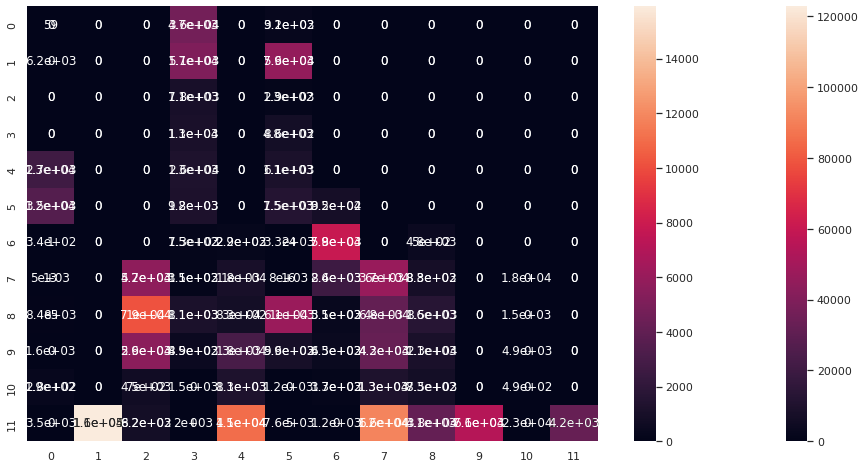

In [100]:
print_metrics(train_labels, kmeans.labels_)
print("-" * 20)
print_metrics(test_labels, kmeans.predict(test_vectors))

In [101]:
# Let's try an svm
def train_svm(train_vectors, train_labels):
    classifier = svm.LinearSVC()
    classifier.fit(train_vectors, train_labels)
    return classifier
# train_svm(train_vectors, train_labels)

LinearSVC()

label           precision  recall     fscore     support   
log            :       1.00       1.00       1.00       4994
planks         :       0.93       1.00       0.96      11005
crafting_table :       0.89       0.84       0.87       1182
sticks         :       0.90       0.91       0.91       1934
wooden_pickaxe :       1.00       1.00       1.00       5064
cobblestone    :       0.89       0.89       0.89       7192
stone_pickaxe  :       0.95       1.00       0.97       8670
furnace        :       0.72       0.78       0.75      16423
iron_ore       :       0.80       0.82       0.81      24324
iron_ingot     :       0.48       0.37       0.42      15665
iron_pickaxe   :       1.00       0.58       0.73       4490
diamond        :       0.97       1.00       0.98      55047
Overall Accuracy: 0.8664914417590871


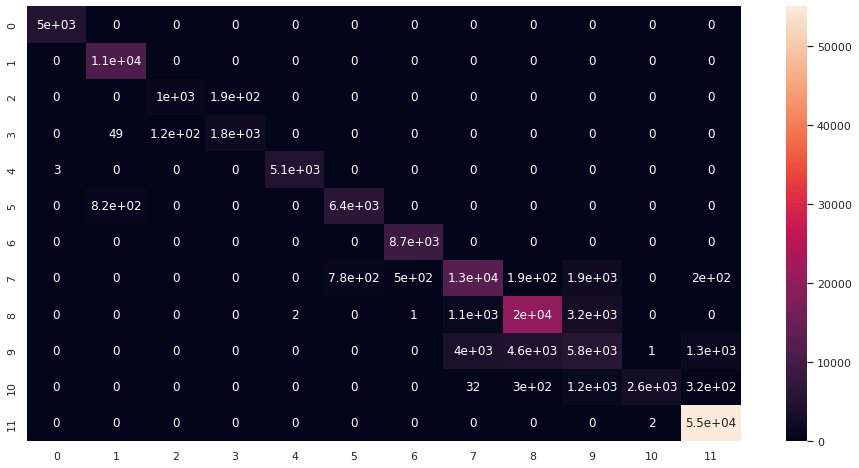

In [105]:
# predictions = classifier.predict(test_vectors)
# print_metrics(test_labels, predictions)

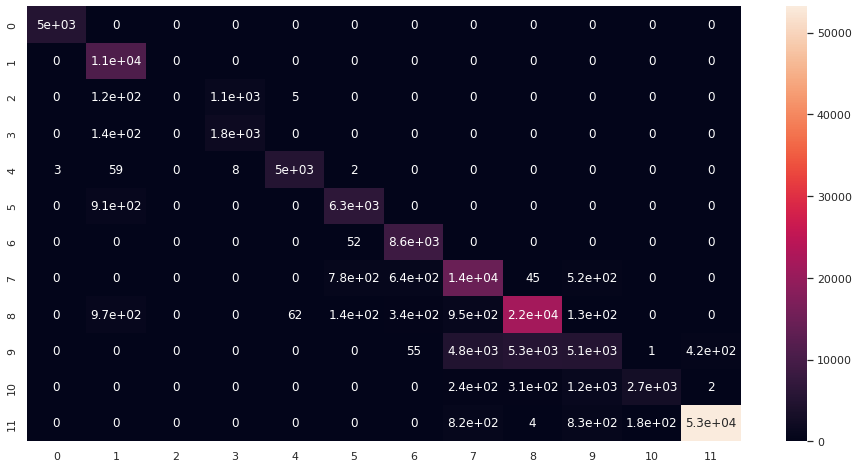

/home/art/anaconda3/envs/minerl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


label           precision  recall     fscore     support   
log            :       1.00       1.00       1.00       4994
planks         :       0.83       1.00       0.91      11005
crafting_table :       0.00       0.00       0.00       1182
sticks         :       0.63       0.93       0.75       1934
wooden_pickaxe :       0.99       0.99       0.99       5064
cobblestone    :       0.87       0.87       0.87       7192
stone_pickaxe  :       0.89       0.99       0.94       8670
furnace        :       0.68       0.88       0.77      16423
iron_ore       :       0.79       0.89       0.84      24324
iron_ingot     :       0.66       0.32       0.43      15665
iron_pickaxe   :       0.94       0.61       0.74       4490
diamond        :       0.99       0.97       0.98      55047
Overall Accuracy: 0.8647669722418104
--------------------------------------------------


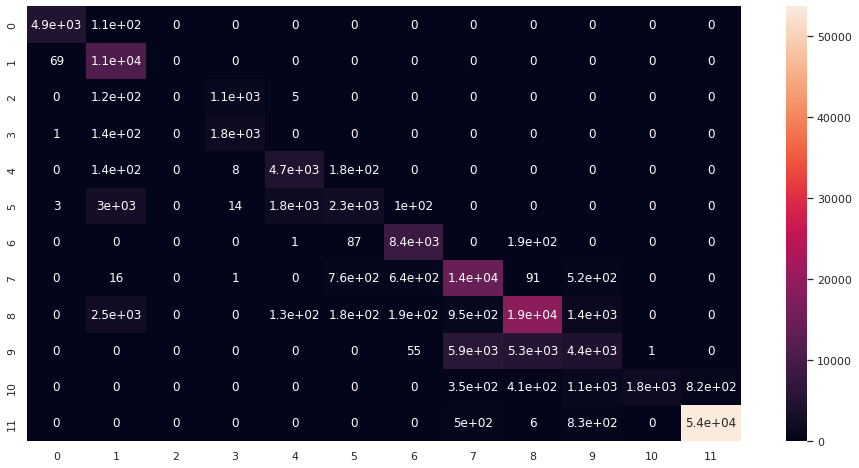

/home/art/anaconda3/envs/minerl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


label           precision  recall     fscore     support   
log            :       0.99       0.98       0.98       4994
planks         :       0.65       0.99       0.78      11005
crafting_table :       0.00       0.00       0.00       1182
sticks         :       0.62       0.93       0.75       1934
wooden_pickaxe :       0.71       0.94       0.81       5064
cobblestone    :       0.66       0.33       0.44       7192
stone_pickaxe  :       0.90       0.97       0.93       8670
furnace        :       0.65       0.88       0.75      16423
iron_ore       :       0.76       0.78       0.77      24324
iron_ingot     :       0.53       0.28       0.37      15665
iron_pickaxe   :       1.00       0.39       0.57       4490
diamond        :       0.98       0.98       0.98      55047
Overall Accuracy: 0.8103532277710109
--------------------------------------------------


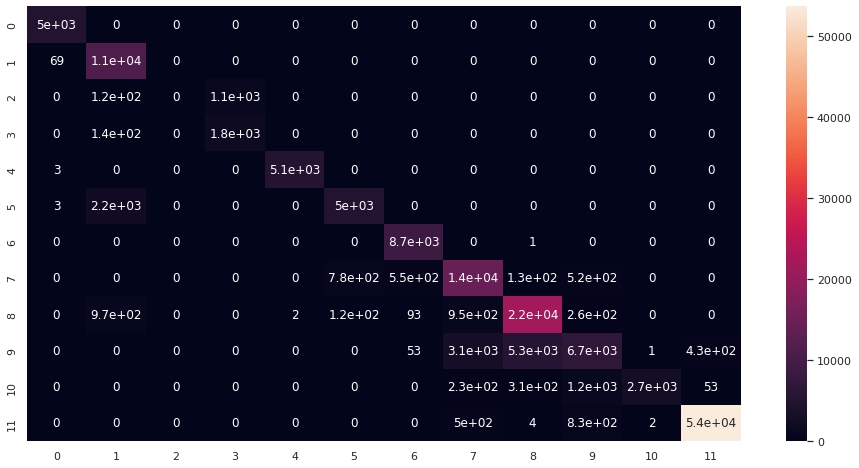

/home/art/anaconda3/envs/minerl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


label           precision  recall     fscore     support   
log            :       0.99       1.00       0.99       4994
planks         :       0.76       0.99       0.86      11005
crafting_table :       0.00       0.00       0.00       1182
sticks         :       0.63       0.93       0.75       1934
wooden_pickaxe :       1.00       1.00       1.00       5064
cobblestone    :       0.85       0.69       0.76       7192
stone_pickaxe  :       0.93       1.00       0.96       8670
furnace        :       0.75       0.88       0.81      16423
iron_ore       :       0.79       0.90       0.84      24324
iron_ingot     :       0.71       0.43       0.53      15665
iron_pickaxe   :       1.00       0.60       0.75       4490
diamond        :       0.99       0.98       0.98      55047
Overall Accuracy: 0.8714468876210013
--------------------------------------------------


/home/art/anaconda3/envs/minerl/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


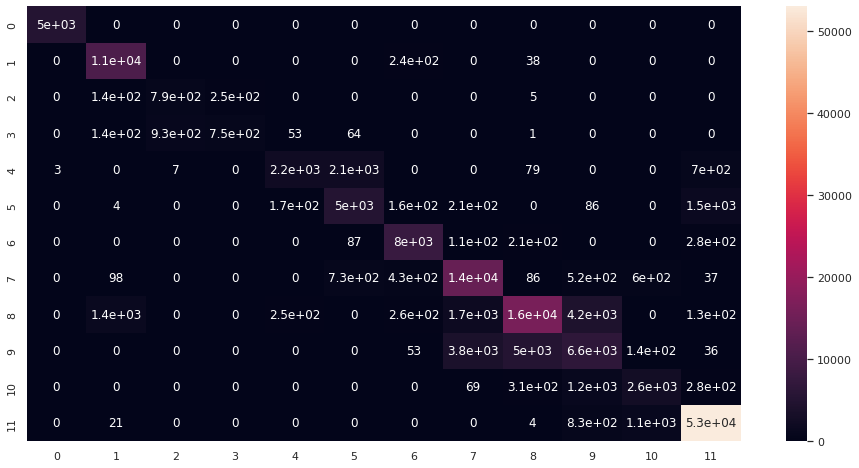

label           precision  recall     fscore     support   
log            :       1.00       1.00       1.00       4994
planks         :       0.85       0.97       0.91      11005
crafting_table :       0.46       0.67       0.54       1182
sticks         :       0.75       0.39       0.51       1934
wooden_pickaxe :       0.82       0.43       0.56       5064
cobblestone    :       0.63       0.70       0.66       7192
stone_pickaxe  :       0.87       0.92       0.90       8670
furnace        :       0.70       0.85       0.77      16423
iron_ore       :       0.74       0.67       0.70      24324
iron_ingot     :       0.49       0.42       0.45      15665
iron_pickaxe   :       0.58       0.59       0.59       4490
diamond        :       0.95       0.96       0.96      55047
Overall Accuracy: 0.801128277453683
--------------------------------------------------


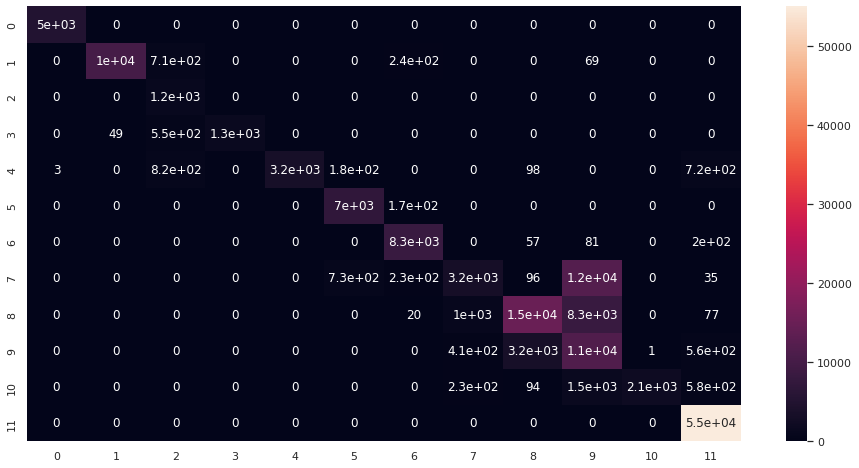

label           precision  recall     fscore     support   
log            :       1.00       1.00       1.00       4994
planks         :       1.00       0.91       0.95      11005
crafting_table :       0.36       1.00       0.53       1182
sticks         :       1.00       0.69       0.82       1934
wooden_pickaxe :       1.00       0.64       0.78       5064
cobblestone    :       0.88       0.98       0.93       7192
stone_pickaxe  :       0.93       0.96       0.94       8670
furnace        :       0.66       0.19       0.30      16423
iron_ore       :       0.81       0.61       0.70      24324
iron_ingot     :       0.34       0.73       0.47      15665
iron_pickaxe   :       1.00       0.47       0.64       4490
diamond        :       0.96       1.00       0.98      55047
Overall Accuracy: 0.7871722546317071
--------------------------------------------------


In [111]:
def train_sgds():
    sgd_models = {}
    for loss in ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']:
        model = SGDClassifier(loss=loss, max_iter=50)
        model.fit(train_vectors, train_labels)
        sgd_models[loss] = model
        print_metrics(test_labels, model.predict(test_vectors))
        print("-" * 50)
    return sgd_models

# Train DNN Classifier

In [23]:
class NatureCNN(nn.Module):
    """
    CNN from DQN nature paper:
        Mnih, Volodymyr, et al.
        "Human-level control through deep reinforcement learning."
        Nature 518.7540 (2015): 529-533.
    Nicked from stable-baselines3:
        https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/common/torch_layers.py
    :param input_shape: A three-item tuple telling image dimensions in (C, H, W)
    :param output_dim: Dimensionality of the output vector
    """

    def __init__(self, input_shape, output_dim):
        super().__init__()
        n_input_channels = input_shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.zeros(1, *input_shape)).shape[1]

        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, output_dim)
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [ ]:
def train_nature_policy_predictor():
    EPOCHS = 5
    LEARNING_RATE = 1e-4
    BATCH_SIZE=64
    network = NatureCNN((3, 64, 64), len(segments)).cuda()
    optimizer = torch.optim.Adam(network.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()

    train_data = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    update_count = 0
    for epoch in range(EPOCHS):
        for iiter, (obs, inventories, actions, rewards, segment_ids) in enumerate(train_data):
            obs = obs.numpy().astype(np.float32).transpose(0,3, 1, 2) # channels first
            obs /= 255.0

            logits = network(torch.from_numpy(obs).cuda())
            loss = loss_fn(logits, segment_ids.cuda())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if iiter % 100 == 0:
                print(f"{iiter}: {loss}")
# nature_network = train_nature_policy_predictor()

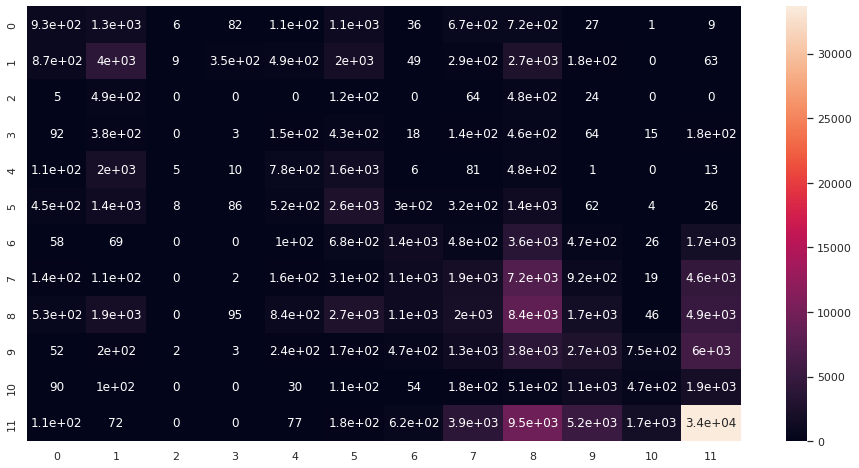

label           precision  recall     fscore     support   
log            :       0.27       0.19       0.22       4994
planks         :       0.33       0.36       0.35      11005
crafting_table :       0.00       0.00       0.00       1182
sticks         :       0.00       0.00       0.00       1934
wooden_pickaxe :       0.22       0.15       0.18       5064
cobblestone    :       0.22       0.36       0.27       7192
stone_pickaxe  :       0.27       0.16       0.20       8670
furnace        :       0.17       0.12       0.14      16423
iron_ore       :       0.21       0.34       0.26      24324
iron_ingot     :       0.22       0.17       0.19      15665
iron_pickaxe   :       0.15       0.11       0.13       4490
diamond        :       0.63       0.61       0.62      55047
Overall Accuracy: 0.36430540419257645


In [127]:

predictions = []
labels = []
for (obs, inventory, action, reward, label) in DataLoader(test_dataset, batch_size=BATCH_SIZE):
    obs = obs.numpy().astype(np.float32).transpose(0,3, 1, 2) # channels first
    obs /= 255.0
    
    logits = network(torch.from_numpy(obs).cuda())
    batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.append(batch_predictions)
    labels.append(label.numpy())

print_metrics(np.concatenate(labels), np.concatenate(predictions))

In [129]:
class InventoryDNN(nn.Module):
    """
    :param input_dim: size of input vector
    :param output_dim: Dimensionality of the output vector
    """

    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, inventories: torch.Tensor) -> torch.Tensor:
        return self.linear(inventories)

0 0: 2.4826598167419434
0 1000: 0.7191249132156372
0 2000: 0.26533713936805725
0 3000: 0.3753623068332672
0 4000: 0.21112112700939178
0 5000: 0.20548030734062195
0 6000: 0.26372215151786804
0 7000: 0.236798956990242
0 8000: 0.11828393489122391
0 9000: 0.18339566886425018
0 10000: 0.1406523436307907
0 11000: 0.17135505378246307
0 12000: 0.16149118542671204
0 13000: 0.14000147581100464
0 14000: 0.1923530101776123
0 15000: 0.1692408174276352
0 16000: 0.10298532992601395
0 17000: 0.07683157920837402
0 18000: 0.08573488891124725
0 19000: 0.08753982186317444
0 20000: 0.08992493897676468
0 21000: 0.14395157992839813
1 0: 0.045969974249601364
1 1000: 0.13951219618320465
1 2000: 0.07342302054166794
1 3000: 0.12091703712940216
1 4000: 0.10041194409132004
1 5000: 0.08786655217409134
1 6000: 0.2797863781452179
1 7000: 0.16340623795986176
1 8000: 0.16745643317699432
1 9000: 0.06559856981039047
1 10000: 0.07300154864788055
1 11000: 0.09382106363773346
1 12000: 0.09082738310098648
1 13000: 0.12686045

In [ ]:
network = InventoryDNN(64, len(segments)).cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_data = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
update_count = 0
for epoch in range(EPOCHS):
    for iiter, (obs, inventories, actions, rewards, segment_ids) in enumerate(train_data):
        
        logits = network(inventories.float().cuda())
        loss = loss_fn(logits, segment_ids.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_count += 1
        if iiter % 1000 == 0:
            print(f"{epoch} {iiter}: {loss}")

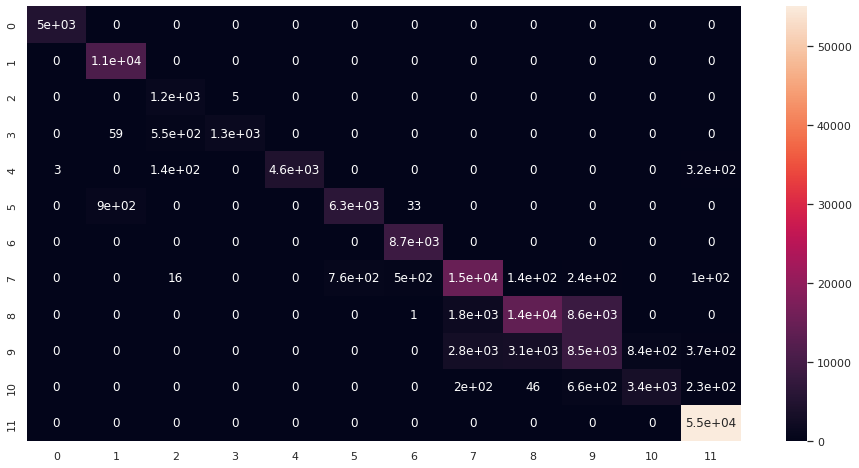

label           precision  recall     fscore     support   
log            :       1.00       1.00       1.00       4994
planks         :       0.92       1.00       0.96      11005
crafting_table :       0.62       1.00       0.77       1182
sticks         :       1.00       0.69       0.81       1934
wooden_pickaxe :       1.00       0.91       0.95       5064
cobblestone    :       0.89       0.87       0.88       7192
stone_pickaxe  :       0.94       1.00       0.97       8670
furnace        :       0.75       0.89       0.82      16423
iron_ore       :       0.81       0.57       0.67      24324
iron_ingot     :       0.47       0.54       0.51      15665
iron_pickaxe   :       0.80       0.75       0.77       4490
diamond        :       0.98       1.00       0.99      55047
Overall Accuracy: 0.8562920700044875


In [130]:
predictions = []
labels = []
for (obs, inventory, action, reward, label) in DataLoader(test_dataset, batch_size=BATCH_SIZE):
    
    
    logits = network(inventory.float().cuda())
    batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.append(batch_predictions)
    labels.append(label.numpy())

print_metrics(np.concatenate(labels), np.concatenate(predictions))

In [131]:
class CombinedDNN(nn.Module):
    def __init__(self, input_shape, inv_dim, hidden_dim, output_dim):
        super().__init__()
        self.nature = NatureCNN(input_shape, hidden_dim)
        self.inventory = InventoryDNN(inv_dim, hidden_dim)

        self.linear = nn.Sequential(
            nn.Linear(hidden_dim * 2, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, observations: torch.Tensor, inventories: torch.Tensor) -> torch.Tensor:
        return self.linear(torch.cat((self.nature(observations), self.inventory(inventories)), dim=1))

0: 2.495154619216919
100: 1.4590870141983032
200: 1.0177860260009766
300: 0.8278391361236572
400: 0.7706823945045471
500: 0.7036045789718628
600: 0.5337154865264893
700: 0.3745594620704651
800: 0.35143446922302246
900: 0.29836487770080566
1000: 0.6487921476364136
1100: 0.3107103407382965
1200: 0.31444692611694336
1300: 0.2620013654232025
1400: 0.4706030786037445
1500: 0.2961827516555786
1600: 0.2671443521976471
1700: 0.3066249191761017
1800: 0.2482052445411682
1900: 0.36451852321624756
2000: 0.2719712555408478
2100: 0.29639893770217896
2200: 0.2042466402053833
2300: 0.27676284313201904
2400: 0.41814717650413513
2500: 0.19988715648651123
2600: 0.15641118586063385
2700: 0.30711060762405396
2800: 0.4623839259147644
2900: 0.13182473182678223
3000: 0.24625056982040405
3100: 0.1766016185283661
3200: 0.18069812655448914
3300: 0.19016990065574646
3400: 0.11564303934574127
3500: 0.19118738174438477
3600: 0.10621155798435211
3700: 0.05766521766781807
3800: 0.21368230879306793
3900: 0.22301168739

8800: 0.004562569782137871
8900: 0.15284846723079681
9000: 0.0019506450043991208
9100: 0.009445621632039547
9200: 0.0036312092561274767
9300: 0.0037491817492991686
9400: 0.001761042163707316
9500: 0.026442406699061394
9600: 0.026368506252765656
9700: 0.0009102706681005657
9800: 0.014615897089242935
9900: 0.03642456606030464
10000: 0.126247838139534
10100: 0.10138397663831711
10200: 0.08545178920030594
10300: 0.012177613563835621
10400: 0.014541561715304852
10500: 0.026152560487389565
10600: 0.003711598226800561
10700: 0.003453043522313237
10800: 0.0026694179978221655
10900: 0.0003307349397800863
11000: 0.0011702394112944603
11100: 0.005454066209495068
11200: 0.003798492718487978
11300: 0.0029683802276849747
11400: 0.006076699122786522
11500: 0.05440956726670265
11600: 0.013646666891872883
11700: 0.07460292428731918
11800: 0.017039518803358078
11900: 0.0005769024137407541
12000: 0.018726682290434837
12100: 0.0020367735996842384
12200: 0.0006893925601616502
12300: 0.0047234660014510155
1

16100: 0.003029122017323971
16200: 0.001049412414431572
16300: 0.012703807093203068
16400: 0.006287015043199062
16500: 0.0001530211593490094
16600: 0.00027020095149055123
16700: 0.4376108944416046
16800: 0.0006629148847423494
16900: 0.0011265369830653071
17000: 0.011739174835383892
17100: 0.0006969814421609044
17200: 0.00017191712686326355
17300: 0.00014431856106966734
17400: 0.09301397949457169
17500: 0.001096503110602498
17600: 0.00027317163767293096
17700: 0.0004861067864112556
17800: 0.0001738546707201749
17900: 0.0030903462320566177
18000: 0.0011856937780976295
18100: 0.00014333853323478252
18200: 0.0001099310684367083
18300: 0.000533544400241226
18400: 0.004467918537557125
18500: 0.00014197957352735102
18600: 0.0009678140631876886
18700: 0.0009881594451144338
18800: 0.0024371196050196886
18900: 0.0007022270583547652
19000: 0.00018355877546127886
19100: 0.0005519231199286878
19200: 0.10961344838142395
19300: 0.0011950560146942735
19400: 0.0015818651299923658
19500: 0.0005583799793

1100: 0.0001502237719250843
1200: 0.00117776682600379
1300: 0.003088653553277254
1400: 0.0002452138578519225
1500: 6.514669803436846e-05
1600: 0.0011052277404814959
1700: 2.2797839847044088e-05
1800: 0.00029873219318687916
1900: 6.762226985301822e-05
2000: 0.00502534257248044
2100: 0.0006830734200775623
2200: 4.975609772372991e-05
2300: 5.9050471463706344e-05
2400: 0.0006752017652615905
2500: 0.00042792290332727134
2600: 0.0003129396354779601
2700: 7.815864228177816e-05
2800: 2.9176253519835882e-05
2900: 0.014983298256993294
3000: 0.0004399772733449936
3100: 5.811315986647969e-06
3200: 0.0001303374592680484
3300: 5.730768680223264e-05
3400: 0.00021736914641223848
3500: 0.0001419664768036455
3600: 1.3143784599378705e-05
3700: 9.320015669800341e-05
3800: 0.00014305101649370044
3900: 0.00013489523553289473
4000: 8.094796066870913e-05
4100: 0.0013501300709322095
4200: 0.02129543013870716
4300: 0.0004971851594746113
4400: 0.00027901207795366645
4500: 0.0005225143395364285
4600: 3.9327911508

In [ ]:
EPOCHS = 5
LEARNING_RATE = 1e-4
BATCH_SIZE=64
network = CombinedDNN((3, 64, 64), 64, 512, len(segments)).cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_data = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
update_count = 0
for epoch in range(EPOCHS):
    for iiter, (obs, inventories, actions, rewards, segment_ids) in enumerate(train_data):
        obs = obs.numpy().astype(np.float32).transpose(0,3, 1, 2) # channels first
        obs /= 255.0
        
        logits = network(torch.from_numpy(obs).cuda(), inventories.float().cuda())
        loss = loss_fn(logits, segment_ids.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if iiter % 100 == 0:
            print(f"{iiter}: {loss}")

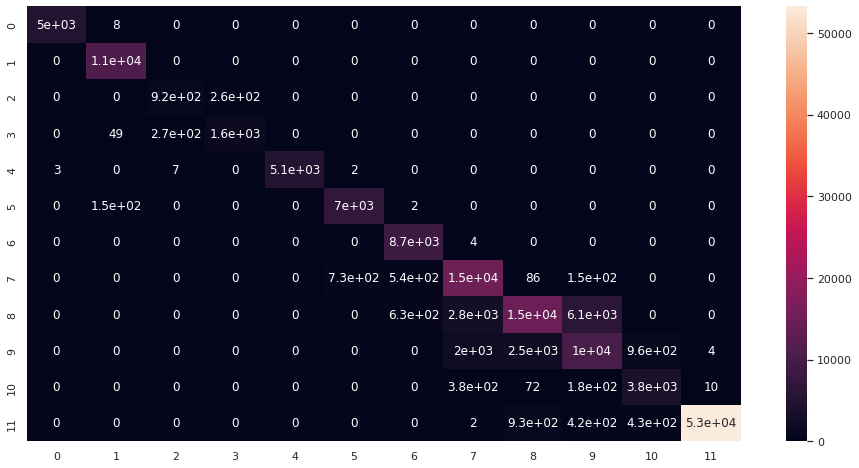

label           precision  recall     fscore     support   
log            :       1.00       1.00       1.00       4994
planks         :       0.98       1.00       0.99      11005
crafting_table :       0.77       0.78       0.77       1182
sticks         :       0.86       0.83       0.85       1934
wooden_pickaxe :       1.00       1.00       1.00       5064
cobblestone    :       0.91       0.98       0.94       7192
stone_pickaxe  :       0.88       1.00       0.94       8670
furnace        :       0.74       0.91       0.81      16423
iron_ore       :       0.81       0.61       0.69      24324
iron_ingot     :       0.60       0.65       0.62      15665
iron_pickaxe   :       0.73       0.86       0.79       4490
diamond        :       1.00       0.97       0.98      55047
Overall Accuracy: 0.8734854798384512


In [134]:
predictions = []
labels = []
for (obs, inventory, action, reward, label) in DataLoader(test_dataset, batch_size=BATCH_SIZE):
    
    obs = obs.numpy().astype(np.float32).transpose(0,3, 1, 2) # channels first
    obs /= 255.0
    logits = network(torch.from_numpy(obs).cuda(), inventory.float().cuda())
    batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.append(batch_predictions)
    labels.append(label.numpy())

print_metrics(np.concatenate(labels), np.concatenate(predictions))

In [140]:
with open('../train/linear_svc_policy.pkl', 'wb') as f:
    pickle.dump(classifier, f)
    
torch.save(network, '../train/combined_policy.pt')

# Cluster Actions

In [19]:
def train_action_kmeans(train_dataset, n_actions):
    # Get all action vectors
    action_vectors = [train_dataset[i][2] for i in range(len(train_dataset))]
    kmean_actions = KMeans(n_clusters=n_actions).fit(action_vectors)
    return kmean_actions

In [20]:
kmeans_actions = train_action_kmeans(train_dataset, 180)

In [21]:
def save_actions_kmeans(kmeans_actions):
    with open('../train/kmeans_actions.pkl', 'wb') as f:
        pickle.dump(kmeans_actions, f)
save_actions_kmeans(kmeans_actions)

In [15]:
def load_actions_kmeans(path='../train/kmeans_actions.pkl'):
    with open(path, 'rb') as f:
        x = pickle.load(f)
    return x
kmeans_actions = load_actions_kmeans()

# Train segment BCs

In [18]:
# Transform Images
def normalize_observation(obs):
    obs = obs.numpy().astype(np.float32).transpose(0, 3, 1, 2)
    return obs / 255.0


im_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip()
])
def transform_observation(obs):
    obs = normalize_observation(obs)
    obs = torch.from_numpy(obs).cuda()
    return im_transforms(obs)

In [24]:
def train_policy_on_segment(train_data_dict, test_data_dict, kmeans_actions, name, network=None, learning_rate=1e-4, epochs=5, batch_size=64):
    n_clusters= len(kmeans_actions.cluster_centers_)
    print(n_clusters)
    if network is None:
        network = NatureCNN((3, 64, 64), n_clusters).cuda()
    if 'actions' in train_data_dict:
        train_dataset = PolicyDataset({'log': train_data_dict}, labels_to_ids)
    else:
        train_dataset = PolicyDataset(train_data_dict, labels_to_ids)
    if 'actions' in test_data_dict:
        test_dataset = PolicyDataset({'log': test_data_dict}, labels_to_ids)
    else:
        test_dataset = PolicyDataset(test_data_dict, labels_to_ids)
    
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()
    train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        for iiter, (obs, inventories, actions, rewards, segment_ids) in enumerate(train_data):
            obs = transform_observation(obs)
            action_labels = kmeans_actions.predict(actions)
            logits = network(obs)
            loss = loss_fn(logits, torch.from_numpy(action_labels).long().cuda())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if iiter % 1000 == 0:
                print(f"{epoch} {iiter} {loss}")
        test_losses = []
        for obs, _, actions, _, _ in test_data:
            obs = normalize_observation(obs)
            action_labels = kmeans_actions.predict(actions)
            with torch.no_grad():
                logits = network(torch.from_numpy(obs).cuda())
                loss = loss_fn(logits, torch.from_numpy(action_labels).long().cuda()).cpu().numpy()
            test_losses.append(loss)
        print(f"Epoch test loss: {sum(test_losses) / len(test_losses)}")
        torch.save(network, f"../train/{name}_{epoch}.pt")
    return network

In [18]:
%whos

Variable                          Type             Data/Info
------------------------------------------------------------
DATA_DIR                          str              /win_d/data/minerl
DataLoader                        type             <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                           type             <class 'torch.utils.data.dataset.Dataset'>
KMeans                            type             <class 'sklearn.cluster._kmeans.KMeans'>
NatureCNN                         type             <class '__main__.NatureCNN'>
Path                              type             <class 'pathlib.Path'>
PolicyDataset                     type             <class '__main__.PolicyDataset'>
SGDClassifier                     ABCMeta          <class 'sklearn.linear_mo<...>_gradient.SGDClassifier'>
accuracy_score                    function         <function accuracy_score at 0x7f32185e49d0>
confusion_matrix                  function         <function confusion_matrix at 0

In [26]:
base_network = train_policy_on_segment(train_segments,
                                       test_segments,
                                       kmeans_actions,
                                       name="base_bc",
                                       network=None,
                                       learning_rate=1e-4,
                                       epochs=20,
                                       batch_size=64)

180
0 0 5.1767096519470215
0 1000 2.2809064388275146
0 2000 2.3820343017578125
0 3000 2.1024608612060547
0 4000 2.0348193645477295
0 5000 2.051248788833618
0 6000 1.7336270809173584
0 7000 2.755570888519287
0 8000 2.275524377822876
0 9000 1.806136965751648
0 10000 1.99689781665802
0 11000 2.215421676635742
0 12000 1.7458053827285767
0 13000 1.7953219413757324
0 14000 2.2863352298736572
0 15000 1.8962336778640747
0 16000 1.9297982454299927
0 17000 1.4846651554107666
0 18000 1.7558199167251587
0 19000 2.1976516246795654
0 20000 2.146641254425049
0 21000 1.9819762706756592
Epoch test loss: 2.043907738396924
1 0 1.7558923959732056
1 1000 1.8730909824371338
1 2000 1.7200675010681152
1 3000 1.449996829032898
1 4000 1.419165015220642
1 5000 1.7631831169128418
1 6000 1.9139620065689087
1 7000 1.7646483182907104
1 8000 1.6519231796264648
1 9000 1.9633288383483887
1 10000 1.775366187095642
1 11000 1.6903669834136963
1 12000 1.757200837135315
1 13000 2.034013032913208
1 14000 1.7016456127166748
1

13 8000 1.5849738121032715
13 9000 1.2277764081954956
13 10000 1.3989168405532837
13 11000 1.239189624786377
13 12000 1.8409465551376343
13 13000 2.0785162448883057
13 14000 1.4390043020248413
13 15000 1.6432392597198486
13 16000 1.5743658542633057
13 17000 1.1693477630615234
13 18000 1.306541919708252
13 19000 1.484315037727356
13 20000 1.4848262071609497
13 21000 2.2164523601531982
Epoch test loss: 2.0290304503546475
14 0 1.8326902389526367
14 1000 1.532578945159912
14 2000 2.0351788997650146
14 3000 1.4817540645599365
14 4000 1.4226573705673218
14 5000 1.4089231491088867
14 6000 1.6494247913360596
14 7000 1.6143745183944702
14 8000 1.5416911840438843
14 9000 1.2458158731460571
14 10000 1.980991005897522
14 11000 1.4071965217590332
14 12000 0.9021197557449341
14 13000 1.4265753030776978
14 14000 1.7359654903411865
14 15000 1.9458818435668945
14 16000 1.5176053047180176
14 17000 1.439204454421997
14 18000 1.3298369646072388
14 19000 1.3636959791183472
14 20000 1.3052127361297607
14 21

In [27]:
log_network = train_policy_on_segment(train_segments['log'],
                                      test_segments['log'],
                                      kmeans_actions,
                                      name="log_bc",
                                      network=copy.deepcopy(base_network),
                                      learning_rate=1e-4,
                                      epochs=5,
                                      batch_size=64)

180
0 0 1.144813060760498
Epoch test loss: 1.8900261936308462
1 0 1.6090600490570068
Epoch test loss: 1.9749378660057164
2 0 1.5581626892089844
Epoch test loss: 1.9634256030939803
3 0 1.8357805013656616
Epoch test loss: 1.9912302403510371
4 0 1.7839449644088745
Epoch test loss: 2.0208623809150503


In [50]:
from sys import getsizeof

%whos
d = vars()
for n, x in sorted(d.items(), key=lambda x: getsizeof(x[1])):
    print(n, getsizeof(x))

Variable                          Type                          Data/Info
-------------------------------------------------------------------------
DATA_DIR                          str                           /win_d/data/minerl
DataLoader                        type                          <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                           type                          <class 'torch.utils.data.dataset.Dataset'>
KMeans                            type                          <class 'sklearn.cluster._kmeans.KMeans'>
N_ACTIONS                         int                           180
NatureCNN                         type                          <class '__main__.NatureCNN'>
Path                              type                          <class 'pathlib.Path'>
PolicyDataset                     type                          <class '__main__.PolicyDataset'>
SGDClassifier                     ABCMeta                       <class 'sklearn.linear_mo<...>_grad